# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import yaml
from utils import *
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import scipy.misc as scm
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
np.random.seed(0)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected

In [2]:
binary_attribute = 'Young'

# Read config

In [3]:
config = '../configs/celebA_{}_Classifier.yaml'.format(binary_attribute)
config = yaml.load(open(config))
for k in config.keys():
    print(k, config[k])

train ./data/CelebA/train_ids.npy
log_dir ./output/classifier
test ./data/CelebA/test_ids.npy
input_size 128
num_channel 3
image_dir ./data/CelebA/images/
ckpt_dir_continue 
name CelebA-Young
batch_size 32
num_class 1
epochs 5
image_label_dict ./data/CelebA/Young_binary_classification.txt


In [4]:
output_dir = os.path.join('.' + config['log_dir'], config['name'], 'classifier_output')
print(output_dir)

../output/classifier/CelebA-Young/classifier_output


In [5]:
categories, file_names_dict = read_data_file('.' + config['image_label_dict'])
print(categories)

['Young']


# Load saved output from classifier

In [6]:
# Read classifier output
train_or_test = 'train1'
names = np.load(os.path.join(output_dir, 'name_' +train_or_test+'.npy'), allow_pickle=True)
prediction_y = np.load(os.path.join(output_dir, 'prediction_y_' +train_or_test+'.npy'))
true_y = np.load(os.path.join(output_dir, 'true_y_' +train_or_test+'.npy'), allow_pickle=True)
train_or_test = 'test1'
names_i = np.load(os.path.join(output_dir,'name_' +train_or_test+'.npy'), allow_pickle=True)
prediction_y_i = np.load(os.path.join(output_dir, 'prediction_y_' +train_or_test+'.npy'))
true_y_i = np.load(os.path.join(output_dir, 'true_y_' +train_or_test+'.npy'))
print(names.shape, prediction_y.shape, true_y.shape)
print(names_i.shape, prediction_y_i.shape, true_y_i.shape)

(135712,) (135712, 2) (135712, 1)
(66848,) (66848, 2) (66848, 1)


In [7]:
true_y = np.reshape(true_y, [-1, len(categories)])
true_y_i = np.reshape(true_y_i, [-1, len(categories)])

## View results from classifier

In [8]:
for i in range(prediction_y.shape[1]):
    print(categories[i],i)
    if prediction_y.shape[1] == 2:
        j = 1
    else:
        j = i
    print("ROC-AUC train: ", roc_auc_score(true_y[:,i], prediction_y[:,j]))
    try:
        print("ROC-AUC test: ", roc_auc_score(true_y_i[:,i], prediction_y_i[:,j]))
    except:
        a = 0
    print("Accuracy train: ", accuracy_score(true_y[:,i], (prediction_y[:,j]>0.5).astype(int)))
    print("Accuracy test: ", accuracy_score(true_y_i[:,i], (prediction_y_i[:,j]>0.5).astype(int)))
    print("Recall train: ", recall_score(true_y[:,i], (prediction_y[:,j]>0.5).astype(int)))
    print("Recall test: ", recall_score(true_y_i[:,i], (prediction_y_i[:,j]>0.5).astype(int)))
    tp = np.sum((prediction_y[true_y[:,i] == 1,j]>0.5).astype(int))
    tp_i = np.sum((prediction_y_i[true_y_i[:,i] == 1,j]>0.5).astype(int))
    print("Stats train: ", np.unique(true_y[:,i], return_counts=True), tp)
    print("Stats test: ", np.unique(true_y_i[:,i], return_counts=True),tp_i)
    print(confusion_matrix(true_y_i[:,i],  (prediction_y_i[:,j]>0.5).astype(int)))
    print(confusion_matrix(true_y[:,i],  (prediction_y[:,j]>0.5).astype(int)))
    if prediction_y.shape[1] == 2:
        break

Young 0
ROC-AUC train:  0.9444020554586694
ROC-AUC test:  0.9219710722841856
Accuracy train:  0.9016372907333177
Accuracy test:  0.8803255146002872
Recall train:  0.9534797348773427
Recall test:  0.9395651164590265
Stats train:  (array([0., 1.], dtype=float32), array([ 30704, 105008])) 100123
Stats test:  (array([0., 1.], dtype=float32), array([15156, 51692])) 48568
[[10280  4876]
 [ 3124 48568]]
[[ 22240   8464]
 [  4885 100123]]


## Choose a traget class to build explanation

In [9]:
current_index = 0
name = categories[current_index]
print(name)
current_index_prob = 1

Young


## Create a dataframe from results

In [10]:
df_test_results = pd.DataFrame(data = [names_i, true_y_i[:,current_index], prediction_y_i[:,current_index_prob]]).T
df_test_results = df_test_results.rename(index=str, columns={0: "filename", 1: "label", 2:"prob"})
df_test_results['bin'] = np.floor(df_test_results["prob"].astype('float') * 10).astype('int')
print(df_test_results.shape)
print(np.unique(df_test_results['bin'], return_counts=True))
df_test_results.head(3)

(66848, 4)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 5550,  2242,  1786,  1788,  2038,  2407,  3123,  4257,  7206,
       36451]))


,filename,label,prob,bin
0,174499.jpg,0,0.814025,8
1,145818.jpg,1,0.99652,9
2,102565.jpg,1,0.962789,9


In [11]:
df_train_results = pd.DataFrame(data = [names, true_y[:,current_index], prediction_y[:,current_index_prob]]).T
df_train_results = df_train_results.rename(index=str, columns={0: "filename", 1: "label", 2:"prob"})
df_train_results['bin'] = np.floor(df_train_results["prob"].astype('float') * 10).astype('int')
print(df_train_results.shape)
print(np.unique(df_train_results['bin'], return_counts=True))
df_train_results.head(3)

(135712, 4)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([11501,  4550,  3734,  3551,  3789,  4599,  6120,  8766, 14517,
       74585]))


,filename,label,prob,bin
0,149610.jpg,1,0.812212,8
1,054215.jpg,1,0.992104,9
2,050394.jpg,1,0.999601,9


In [12]:
df = pd.concat([df_train_results, df_test_results])
df = df.drop_duplicates()
print(df.shape)
df.head(1)

(202560, 4)


,filename,label,prob,bin
0,149610.jpg,1,0.812212,8


## Plot reliability curve

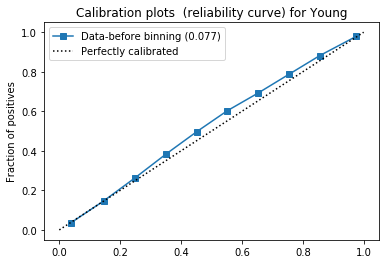

In [13]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df['label']).astype(int)
predicted_prob = np.asarray(df["prob"]).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-before binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
#plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+ name)
plt.legend()
plt.show()

# Create bins

In [14]:
df.head(1)

,filename,label,prob,bin
0,149610.jpg,1,0.812212,8


In [15]:
df.groupby(by='bin').count()

,filename,label,prob
bin,,,
0,17051,17051,17051
1,6792,6792,6792
2,5520,5520,5520
3,5339,5339,5339
4,5827,5827,5827
5,7006,7006,7006
6,9243,9243,9243
7,13023,13023,13023
8,21723,21723,21723


In [16]:
n = 5000

## Caliberated Sampling

In [17]:
for i in range(10):
    df_bin = df.loc[df['bin'] == i]
    print(df_bin.shape)
    print(np.min(df_bin['prob']), np.max(df_bin['prob']))
    print(np.unique(df_bin['label'],return_counts=True))
    df_bin_0 = df.loc[(df['bin'] == i) & (df['label'] ==0)]
    df_bin_1 = df.loc[(df['bin'] == i) & (df['label'] ==1)]
    n_0 = int((1 - (0.1 * i) ) * n)
    if df_bin_0.shape[0] >= n_0:
        df_bin = df_bin_0.sample(n=n_0)
    else:
        df_bin = df_bin_0
        n_0 = df_bin_0.shape[0]
    n_1 = n - n_0
    if df_bin_1.shape[0] >= n_1:
        df_bin = pd.concat([df_bin, df_bin_1.sample(n=n_1)])        
    else:
        df_bin = pd.concat([df_bin, df_bin_1])    
        
    if i == 0:
        df_bin_all = df_bin
    else:
        df_bin_all = pd.concat([df_bin, df_bin_all])
    print(df_bin_all.shape)
    print(np.unique(df_bin['label'], return_counts=True))

(17051, 4)
0.001072528 0.09997948
(array([0.0, 1.0], dtype=object), array([16448,   603]))
(5000, 4)
(array([0.0], dtype=object), array([5000]))
(6792, 4)
0.10001165 0.19999142
(array([0.0, 1.0], dtype=object), array([5786, 1006]))
(10000, 4)
(array([0.0, 1.0], dtype=object), array([4500,  500]))
(5520, 4)
0.20000328 0.29999936
(array([0.0, 1.0], dtype=object), array([4064, 1456]))
(15000, 4)
(array([0.0, 1.0], dtype=object), array([4000, 1000]))
(5339, 4)
0.3000412 0.3999886
(array([0.0, 1.0], dtype=object), array([3289, 2050]))
(20000, 4)
(array([0.0, 1.0], dtype=object), array([3289, 1711]))
(5827, 4)
0.40000042 0.49998057
(array([0.0, 1.0], dtype=object), array([2933, 2894]))
(25000, 4)
(array([0.0, 1.0], dtype=object), array([2933, 2067]))
(7006, 4)
0.5000019 0.5999943
(array([0.0, 1.0], dtype=object), array([2783, 4223]))
(30000, 4)
(array([0.0, 1.0], dtype=object), array([2500, 2500]))
(9243, 4)
0.60003155 0.6999827
(array([0.0, 1.0], dtype=object), array([2848, 6395]))
(35000, 

In [18]:
print(np.unique(df_bin_all['bin'], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


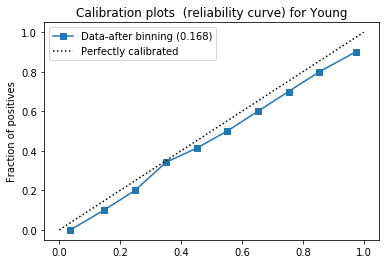

In [19]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
true_label = np.asarray(df_bin_all['label']).astype(int)
predicted_prob = np.asarray(df_bin_all['prob']).astype(float)
fraction_of_positives, mean_predicted_value = calibration_curve(true_label, predicted_prob, n_bins=10)
clf_score = brier_score_loss(true_label, predicted_prob, pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data-after binning', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve) for '+name)
plt.legend()
plt.show()

## Save the output

In [20]:
experiment_dir = os.path.join('.'+config['log_dir'], config['name'], 'explainer_input')

In [21]:
print(experiment_dir,name)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

../output/classifier/CelebA-Young/explainer_input Young


In [22]:
df_temp = df_bin_all[['filename', 'bin']]
df_temp.to_csv(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), sep = ' ', index = None, header = None)
print(df_temp.shape)
one_line = str(df_temp.shape[0]) + '\n'
second_line = "0-0.09 0.1-0.19 0.2-0.29 0.3-0.39 0.4-0.49 0.5-0.59 0.6-0.69 0.7-0.79 0.8-0.89 0.9-0.99\n"
with open(os.path.join(experiment_dir, 'list_attr_celeba_'+name+'.txt'), 'r+') as fp:
    lines = fp.readlines()     # lines is list of line, each element '...\n'
    lines.insert(0, one_line)  # you can use any index if you know the line index
    lines.insert(1, second_line)
    fp.seek(0)                 # file pointer locates at the beginning to write the whole file again
    fp.writelines(lines) 

df_bin_all.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ', index = None)
df_test_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Test_'+name+'.csv'), sep = ' ', index = None)
df_train_results.to_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_All_Train_'+name+'.csv'), sep = ' ', index = None)

(50000, 2)


In [23]:
df_combine = pd.read_csv(os.path.join(experiment_dir, 'Data_Output_Classifier_'+name+'.csv'), sep = ' ')

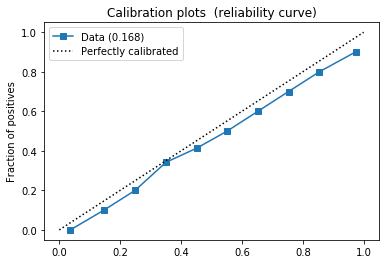

In [24]:
#Reliability Curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)

fraction_of_positives, mean_predicted_value = calibration_curve(df_combine['label'], df_combine["prob"], n_bins=10)
clf_score = brier_score_loss(df_combine['label'], df_combine["prob"], pos_label=1)
plt.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % ('Data', clf_score))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.ylim([-0.05, 1.05])
plt.title('Calibration plots  (reliability curve)')
plt.legend()
plt.show()